In [19]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import lightning.pytorch as pl
from tqdm.autonotebook import tqdm
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import  TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Monkey path for backward compatibility
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool

def read_df(base_path):
    df = pd.read_csv(base_path)
    df.dropna(inplace=True)
    return df

df = read_df('{}/sales.csv'.format(os.path.dirname(os.getcwd())))
df

,date,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt
0,2018-09-27,19194.0,21046.0,12573.0,10720.0,3309.0,9791.0,26523.0
1,2018-10-04,13292.0,14721.0,6916.0,7645.0,2557.0,6981.0,17594.0
2,2018-10-11,19954.0,20708.0,7495.0,9138.0,3632.0,9956.0,23666.0
3,2018-10-18,17547.0,20016.0,7913.0,9693.0,3565.0,7894.0,20586.0
4,2018-10-25,17420.0,20397.0,8887.0,12132.0,3415.0,7495.0,19395.0
...,...,...,...,...,...,...,...,...
98,2020-08-13,10351.0,29723.0,2574.0,2782.0,9064.0,8874.0,19223.0
99,2020-08-20,11852.0,25028.0,6210.0,6211.0,4999.0,7635.0,21342.0
100,2020-08-27,11851.0,19010.0,9540.0,8123.0,2417.0,6746.0,17373.0
101,2020-09-03,10448.0,17389.0,9732.0,8797.0,1935.0,6406.0,15197.0


In [20]:
# Question 2-1: What can be said about the overall trend and seasonality of sales? What of the
# individual product type?

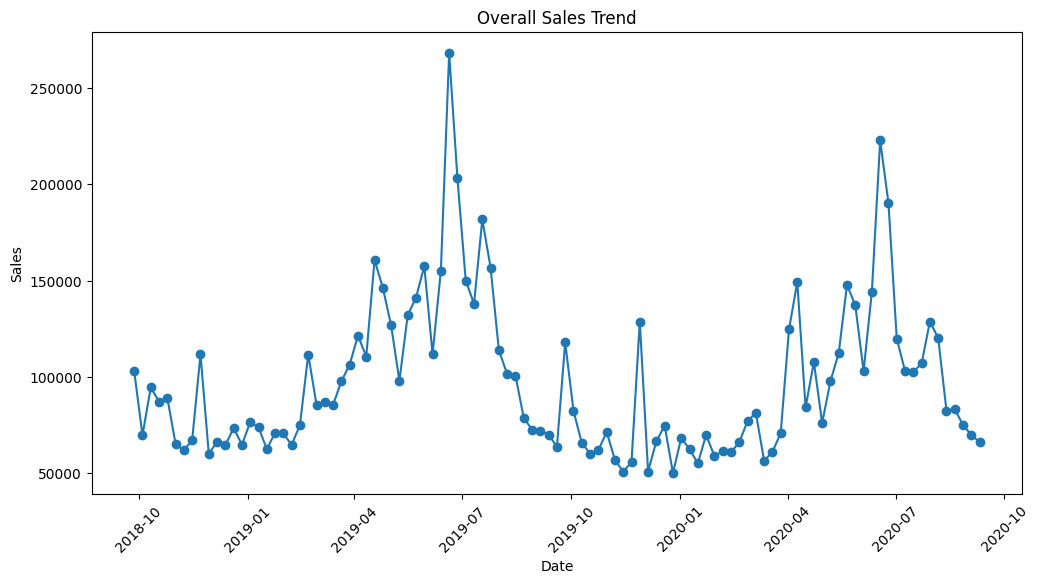

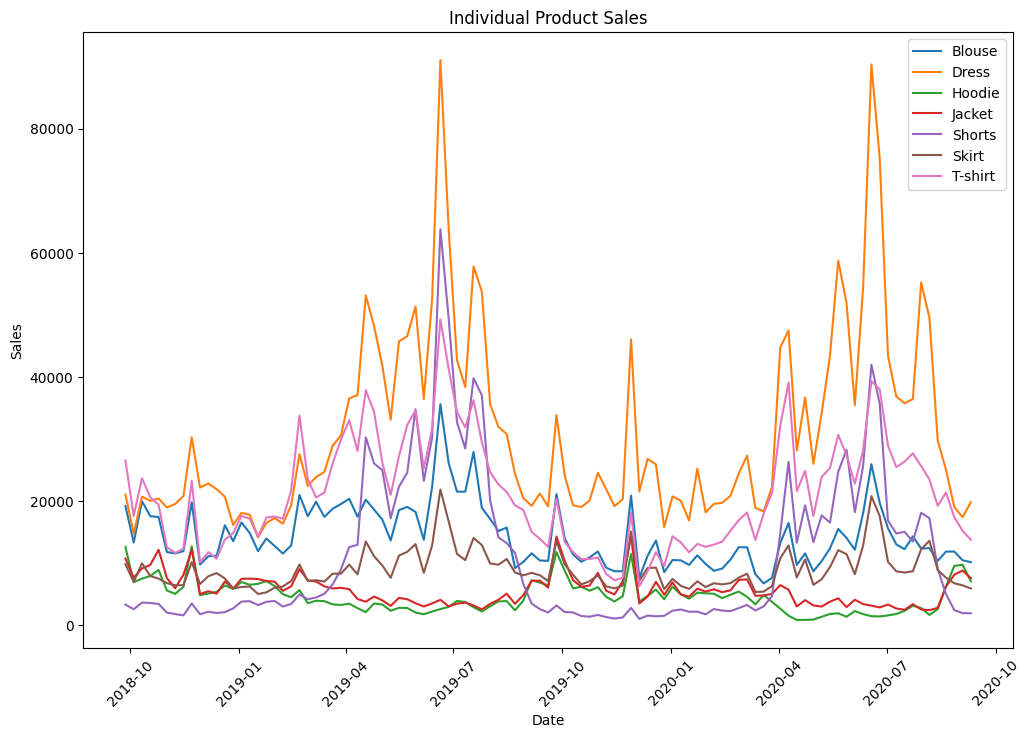

In [21]:


def analyze_sales(data):
    # Calculate the overall sales trend
    dates = pd.to_datetime(data['date'])

    sales = data.iloc[:, 1:].sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, sales, marker='o')
    plt.xticks(rotation=45)
    plt.title('Overall Sales Trend')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
    
    # # Calculate and plot the seasonality of individual product types
    product_types = data.columns[1:]
    
    plt.figure(figsize=(12, 8))
    # dates2 = df.story_point.resample('W', on='date').sum()
    for product_type in product_types:
        plt.plot(dates, data[product_type], label=product_type)
    
    plt.xticks(rotation=45)
    plt.title('Individual Product Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(loc='best')
    plt.show()


# Call the function to analyze the sales
analyze_sales(df)

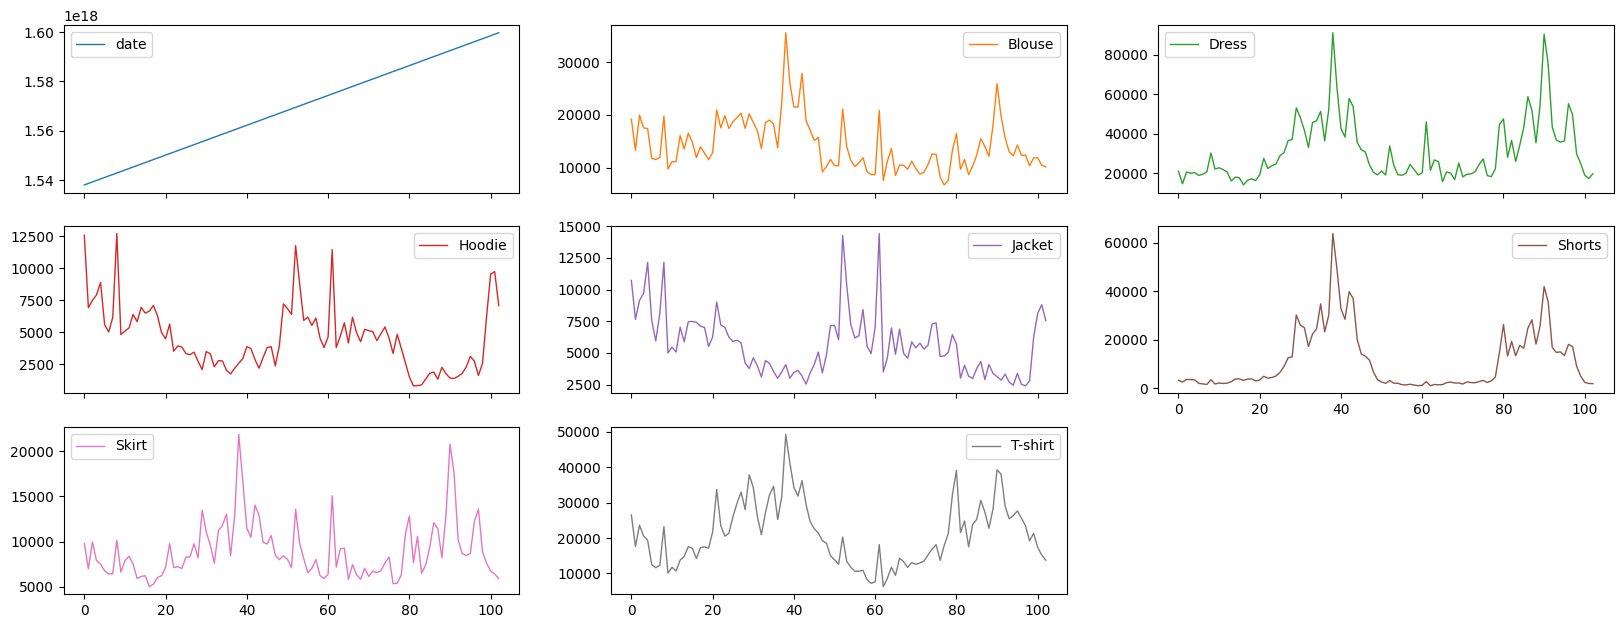

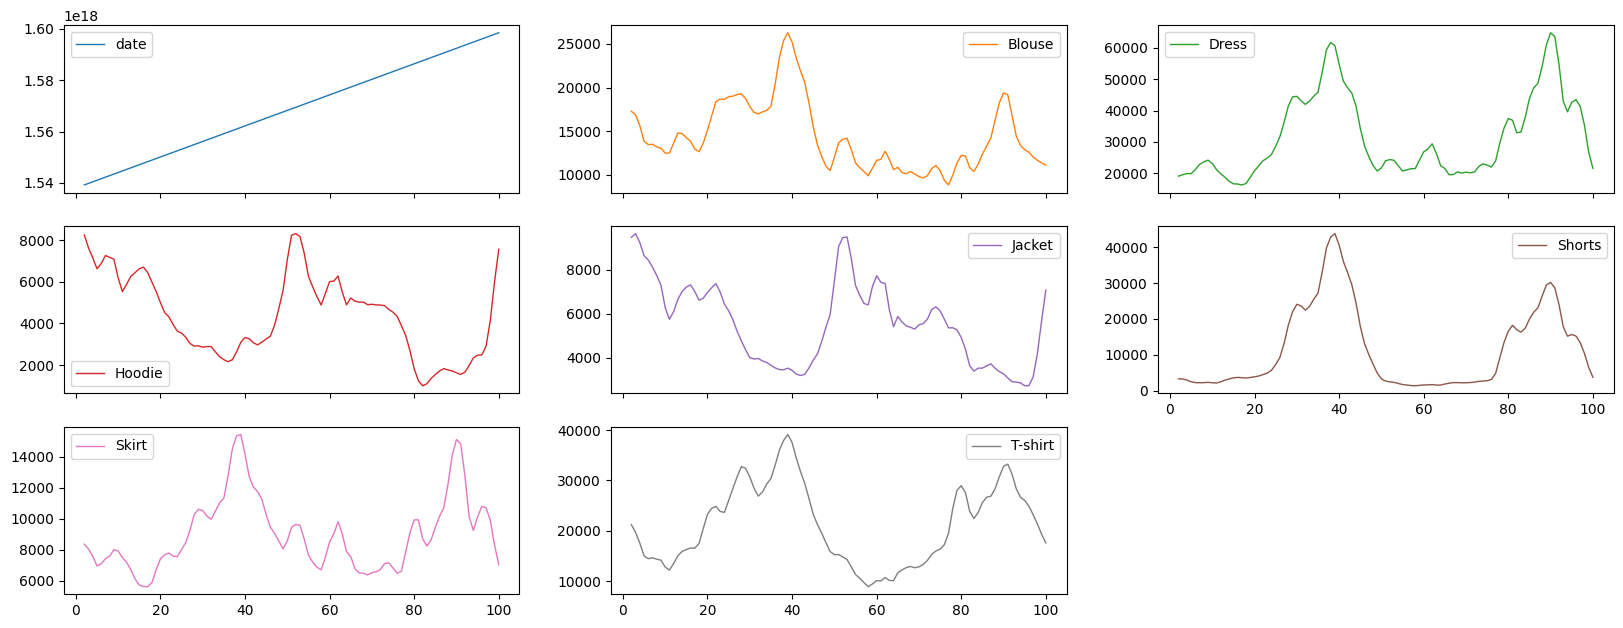

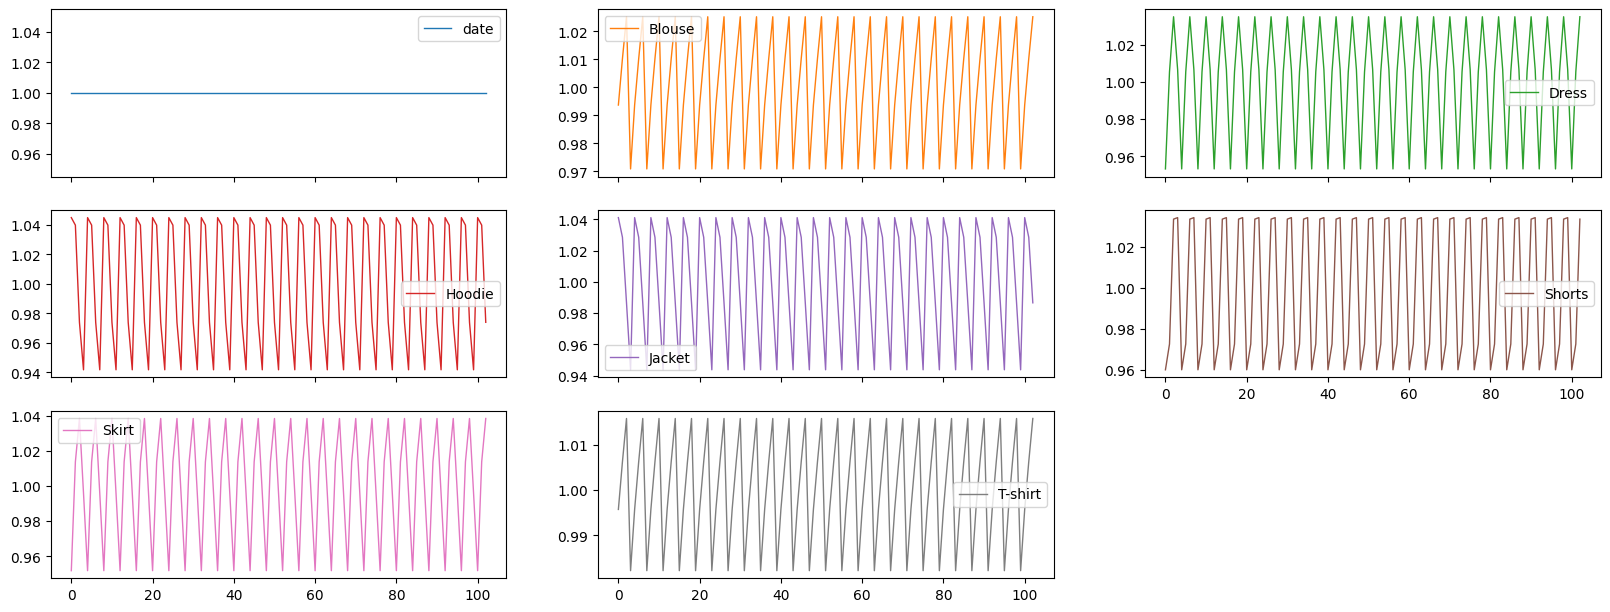

In [26]:
 
def trend_season_decompose(df):
    df['date'] = pd.to_datetime(df['date'])

    observed_dict = {}

    trend_dict = {}
    seasonal_dict = {}

    for ts in df.columns:
        decomposition = seasonal_decompose(df[ts].dropna(),model='multiplicative',period=4)
        observed_dict[ts] = decomposition.observed
        trend_dict[ts] = decomposition.trend
        seasonal_dict[ts] = decomposition.seasonal

    pd.DataFrame(observed_dict).plot(figsize=(20,10),subplots=True, layout=(4, 3), linewidth=1);
    pd.DataFrame(trend_dict).plot(figsize=(20,10), subplots=True, layout=(4, 3), linewidth=1);
    pd.DataFrame(seasonal_dict).plot(figsize=(20,10), subplots=True, layout=(4, 3), linewidth=1);
trend_season_decompose(df)
    

In [19]:
# Question 2-2: Are there correlations between sales of some product types, and if so, which?


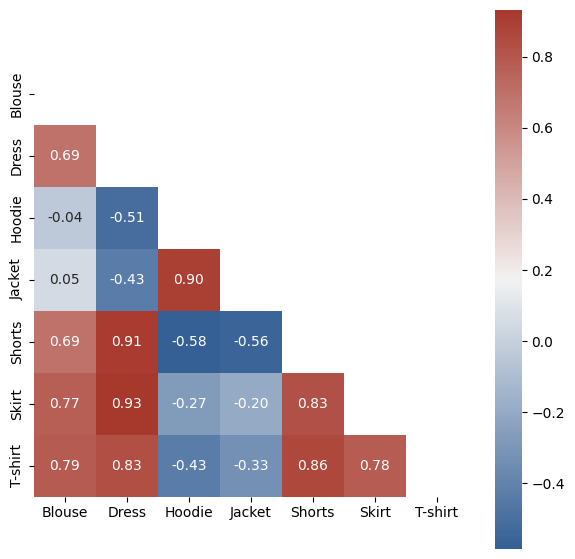

In [4]:
def timeseries_correlation(df):

    df_num = df[df.columns[1:]]

    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    matrix = df_num.corr(method="pearson")
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show();
timeseries_correlation(df)


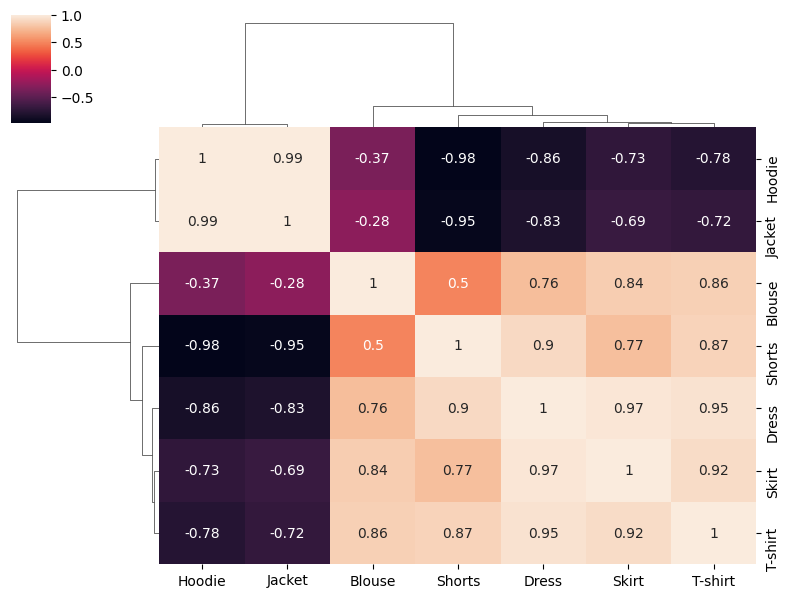

In [12]:
### seasonality of each time series influences others:

def seasonality_influences(df):
    '''
    seasonality of each time series influences others
    '''
    df_num = df[df.columns[1:]]
    seasonality_dict = {
        ts: seasonal_decompose(df[ts], period=4).seasonal for ts in df_num.columns
    }

    # Compute correlation matrix
    seasonality_corr = pd.DataFrame(seasonality_dict).corr()
    sns.clustermap(seasonality_corr, annot=True, figsize=(8,6))
    plt.show();

seasonality_influences(df)



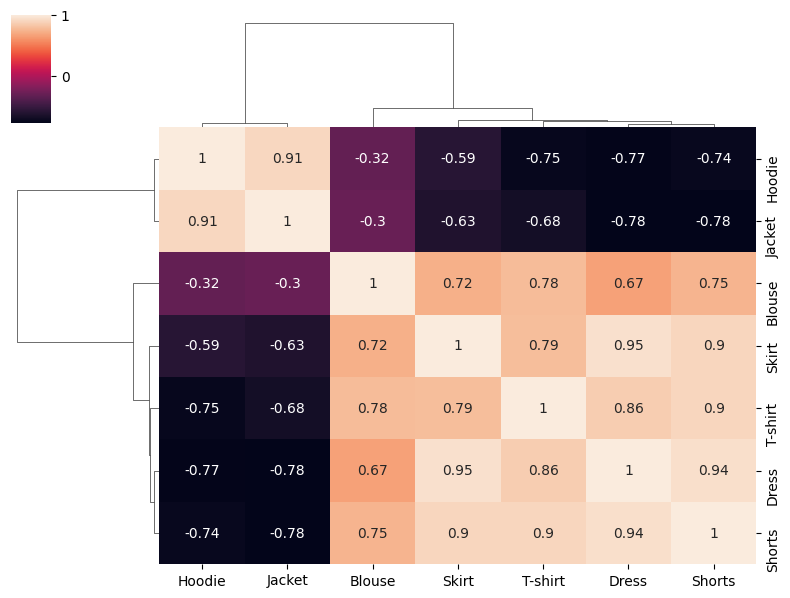

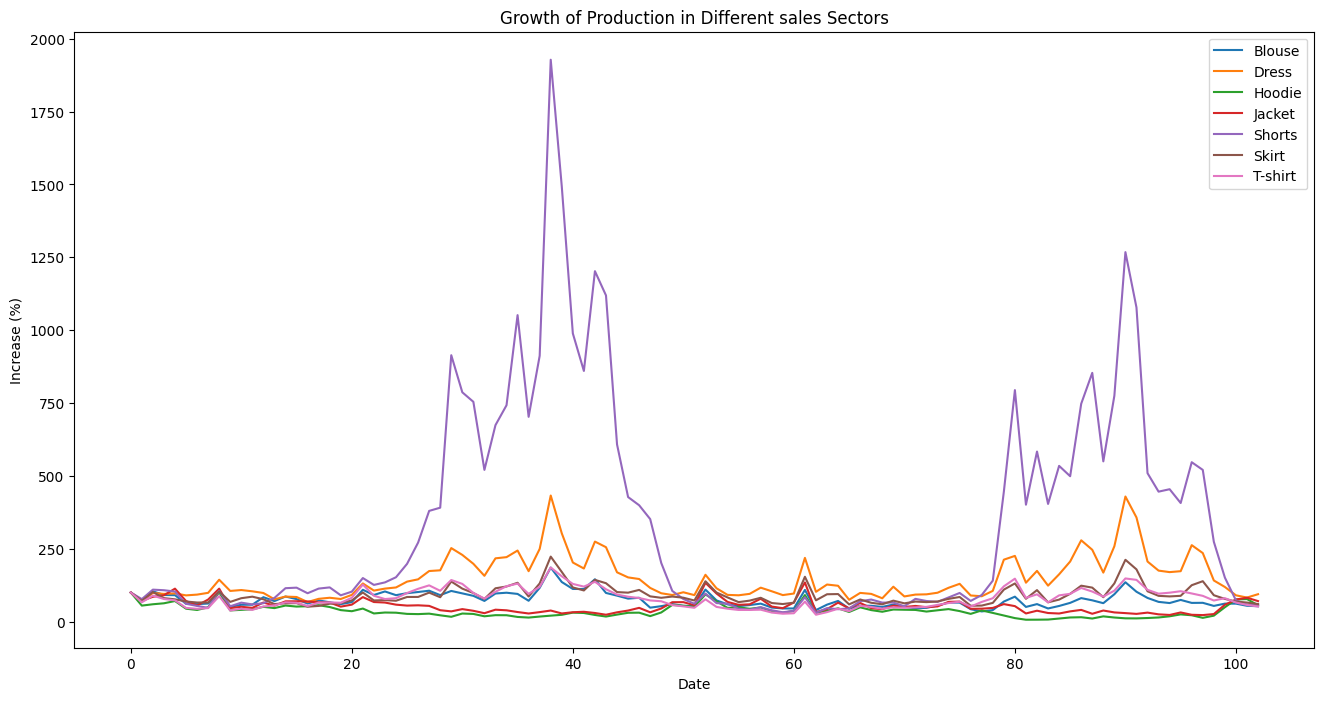

In [4]:
### trends of each time series influences others:
def trend_influences(df):
    df_num = df[df.columns[1:]]
    trend_dict = {
        ts: seasonal_decompose(df_num[ts].dropna(), period=4).trend for ts in df_num.columns
    }

    # Compute corr matrix
    trend_corr = pd.DataFrame(trend_dict).corr()

    sns.clustermap(trend_corr, annot=True,figsize=(8,6))
    plt.show();


    normalized = df_num.div(df_num.iloc[0]).mul(100)

    normalized.plot(figsize=(16, 8), title="Growth of Production in Different sales Sectors")
    plt.xlabel("Date")
    plt.ylabel("Increase (%)");

trend_influences(df)

In [10]:
# Question 2-3 Select a single product type and make forecast about its sales for 5 time periods
# (weeks) from the last observed data point. Please include confidence interval of this
# forecast.


In [5]:

def feature_preprocessing(df):
    data = df[["Dress","Blouse","Hoodie","Jacket","Shorts","Skirt","T-shirt"]]
    data['date'] = pd.to_datetime(df['date'])
    data['group_id'] = "1"
    data["time_idx"] = range(0, len(data))
    data["month"] = data.date.dt.month.astype(str)  # categories have be strings
    return data
feature_preprocessing(df)

,Dress,Blouse,Hoodie,Jacket,Shorts,Skirt,T-shirt,date,group_id,time_idx,month
0,21046.0,19194.0,12573.0,10720.0,3309.0,9791.0,26523.0,2018-09-27,1,0,9
1,14721.0,13292.0,6916.0,7645.0,2557.0,6981.0,17594.0,2018-10-04,1,1,10
2,20708.0,19954.0,7495.0,9138.0,3632.0,9956.0,23666.0,2018-10-11,1,2,10
3,20016.0,17547.0,7913.0,9693.0,3565.0,7894.0,20586.0,2018-10-18,1,3,10
4,20397.0,17420.0,8887.0,12132.0,3415.0,7495.0,19395.0,2018-10-25,1,4,10
...,...,...,...,...,...,...,...,...,...,...,...
98,29723.0,10351.0,2574.0,2782.0,9064.0,8874.0,19223.0,2020-08-13,1,98,8
99,25028.0,11852.0,6210.0,6211.0,4999.0,7635.0,21342.0,2020-08-20,1,99,8
100,19010.0,11851.0,9540.0,8123.0,2417.0,6746.0,17373.0,2020-08-27,1,100,8
101,17389.0,10448.0,9732.0,8797.0,1935.0,6406.0,15197.0,2020-09-03,1,101,9


In [6]:
max_prediction_length = 5 # For the next 5 weeks prediction
max_encoder_length = 12
def prepair_dataset(df):
    data = feature_preprocessing(df)
    training_cutoff = data["time_idx"].max() - max_prediction_length
    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="Dress",
        group_ids=["group_id"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["group_id"],
        time_varying_known_categoricals=["month"],
        time_varying_unknown_reals=[
            "Dress",
            "Blouse",
            "Hoodie",
            "Jacket",
            "Shorts",
            "Skirt",
            "T-shirt"
        ],
        target_normalizer=GroupNormalizer(
            groups=["group_id"], transformation="softplus"
        ),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
    batch_size = 8
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=5)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=5)

    return training, train_dataloader, val_dataloader
prepair_dataset(df)

(TimeSeriesDataSet[length=102](
 	time_idx='time_idx',
 	target='Dress',
 	group_ids=['group_id'],
 	weight=None,
 	max_encoder_length=12,
 	min_encoder_length=6,
 	min_prediction_idx=0,
 	min_prediction_length=1,
 	max_prediction_length=5,
 	static_categoricals=['group_id'],
 	static_reals=['encoder_length', 'Dress_center', 'Dress_scale'],
 	time_varying_known_categoricals=['month'],
 	time_varying_known_reals=['relative_time_idx'],
 	time_varying_unknown_categoricals=[],
 	time_varying_unknown_reals=['Dress', 'Blouse', 'Hoodie', 'Jacket', 'Shorts', 'Skirt', 'T-shirt'],
 	variable_groups={},
 	constant_fill_strategy={},
 	allow_missing_timesteps=False,
 	lags={},
 	add_relative_time_idx=True,
 	add_target_scales=True,
 	add_encoder_length=True,
 	target_normalizer=GroupNormalizer(
 	method='standard',
 	groups=['group_id'],
 	center=True,
 	scale_by_group=False,
 	transformation='softplus',
 	method_kwargs={}
 ),
 	categorical_encoders={'__group_id__group_id': NaNLabelEncoder(add_nan=

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ali/miniforge3/envs/mici/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/ali/miniforge3/envs/mici/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ali/minif

suggested learning rate: 0.39810717055349754


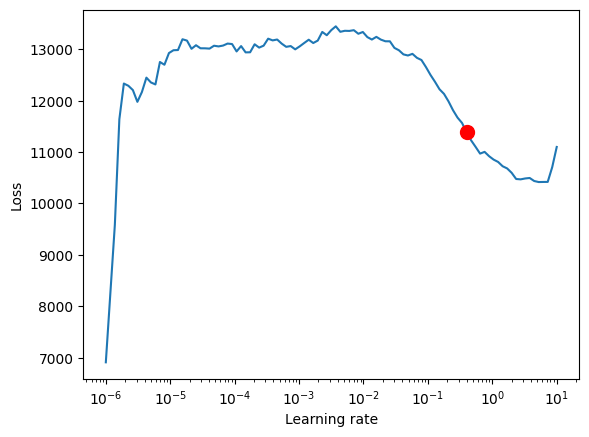

/tmp/ipykernel_78559/3036667634.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 88    
4  | static_variable_selection          | VariableSelectionNetwork        | 664   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 258   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_ls

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.96it/s, v_num=6, train_loss_step=1.15e+4]
Validation: |                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████| 12/12 [00:00<00:00, 15.70it/s, v_num=6, train_loss_step=5.89e+3, val_loss=8.14e+3, train_loss_epoch=1.29e+4]
Validation: |                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████████| 12/12 [00:00<00:00, 14.96it/s, v_num=6, train_loss_step=4.82e+3, val_loss=6.1e+3, train_loss_epoch=6.96e+3]
Validation: |                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████████████

In [7]:


def model_tuner(df):
    training, train_dataloader, val_dataloader = prepair_dataset(df)
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    # logger = TensorBoardLogger("lightning_logs")

    pl.seed_everything(42)
    trainer = pl.Trainer(
        max_epochs=100,
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
        log_every_n_steps=12,
        callbacks=[lr_logger, early_stop_callback])
    # ,
        # logger=logger)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=8,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=1,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=4,  # set to <= hidden_size
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        # reduce learning rate if no improvement in validation loss after x epochs
        reduce_on_plateau_patience=4,
    )
    tuner = pl.tuner.Tuner(trainer)
    res = tuner.lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()
    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)
    
    return trainer, train_dataloader, val_dataloader
trainer, train_dataloader, val_dataloader = model_tuner(df)

/home/ali/miniforge3/envs/mici/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ali/miniforge3/envs/mici/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


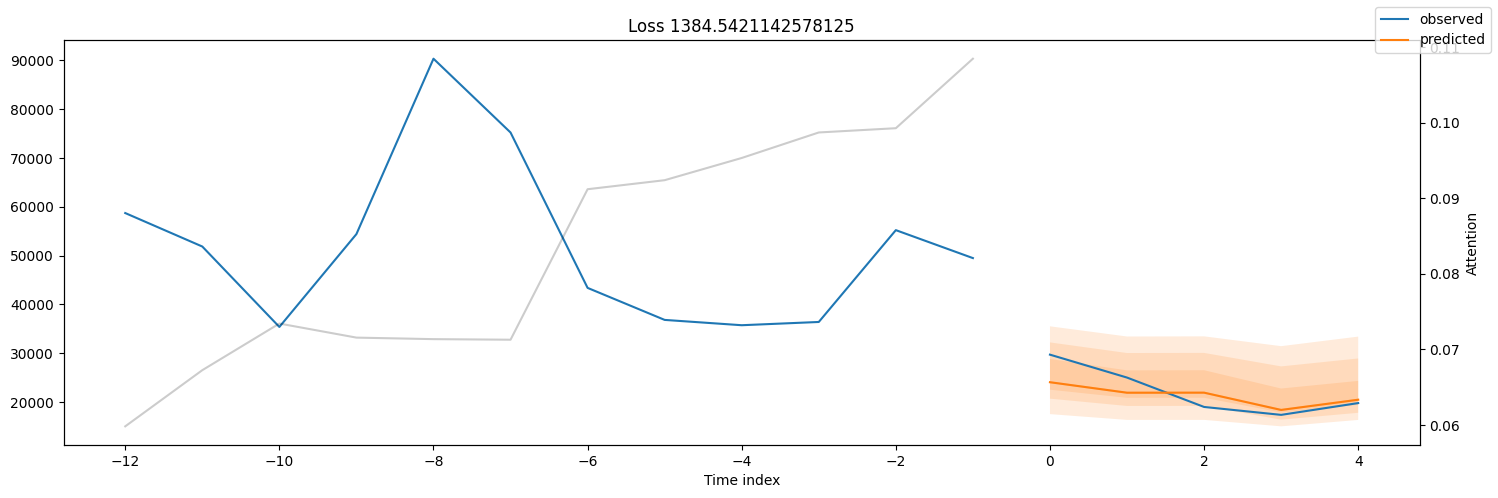

In [8]:

def result_explainer(trainer,val_dataloader):
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_tft.predict(val_dataloader)
    (actuals - predictions).abs().mean()


    raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

    for idx in range(1): # nb of groups combinations
        fig, ax = plt.subplots(figsize=(15,5))
        best_tft.plot_prediction(raw_predictions.x, # network input
                                raw_predictions.output, # network output
                                idx=idx,
                                add_loss_to_title=True,
                                ax=ax)
result_explainer(trainer, val_dataloader)